In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
import lightning as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torchmetrics

In [10]:
# Determine which device to choose
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [12]:
# Transformations for data augmentation
transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomCrop(32, padding=4),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [13]:
# Download CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
validation_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

# Define the model
class VGGCIFAR10Model(pl.LightningModule):
    def __init__(self, num_classes=10):
        super(VGGCIFAR10Model, self).__init__()
        self.batch_size = batch_size

        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),  # New layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
)


        # Dynamically calculate the flattened size
        dummy_input = torch.zeros(1, 3, 32, 32)  # CIFAR-10 images are 32x32 RGB
        flattened_size = self._get_flattened_size(dummy_input)

        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Linear(in_features=flattened_size, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=512, out_features=num_classes),
        )

        # Metrics
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def _get_flattened_size(self, x):
        with torch.no_grad():
            x = self.features(x)
            return x.view(x.size(0), -1).size(1)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def train_dataloader(self):
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=11, persistent_workers=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(validation_dataset, batch_size=self.batch_size, shuffle=False, num_workers=11, persistent_workers=True, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(validation_dataset, batch_size=self.batch_size, shuffle=False, num_workers=11, persistent_workers=True, pin_memory=True)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)  # Flatten the feature map
        out = self.classifier(out)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        loss = nn.CrossEntropyLoss()(out, y)

        # Log training loss and accuracy
        self.train_acc(out, y)
        self.log('train_loss', loss, prog_bar=True, on_epoch=True)
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        loss = nn.CrossEntropyLoss()(out, y)

        # Log validation loss and accuracy
        self.val_acc(out, y)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        loss = nn.CrossEntropyLoss()(out, y)

        # Log test loss and accuracy
        self.test_acc(out, y)
        self.log('test_loss', loss, prog_bar=True, on_epoch=True)
        self.log('test_acc', self.test_acc, prog_bar=True, on_epoch=True)

        return loss


In [15]:
# Instantiate the model
model = VGGCIFAR10Model(num_classes=10).to(device)

# Define EarlyStopping
early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)

# Trainer
trainer = pl.Trainer(callbacks=[early_stop_callback], max_epochs=25, accelerator=device)

# Train the model
trainer.fit(model)

# Validate the model
trainer.test(model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | features   | Sequential         | 389 K  | train
1 | classifier | Sequential         | 33.8 M | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | val_acc    | MulticlassAccuracy | 0      | train
4 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
34.2 M    Trainable params
0         Non-trainable params
34.2 M    Total params
136.848   Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 782/782 [00:59<00:00, 13.22it/s, v_num=129, train_loss_step=1.830, train_acc_step=0.125] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 782/782 [01:00<00:00, 12.82it/s, v_num=129, train_loss_step=2.200, train_acc_step=0.312, val_loss=1.950, val_acc=0.221, train_loss_epoch=2.250, train_acc_epoch=0.167] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 782/782 [00:58<00:00, 13.44it/s, v_num=129, train_loss_step=1.910, train_acc_step=0.188, val_loss=1.910, val_acc=0.222, train_loss_epoch=1.990, train_acc_epoch=0.210] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 782/782 [00:57<00:00, 13.49it/s, v_num=129, train_loss_step=1.660, train_acc_step=0.375, val_loss=1.810, val_acc=0.274, train_loss_epoch=1.890, train_acc_epoch=0.233]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 782/782 [00:57<00:00, 13.54it/s, v_num=129, train_loss_step=1.560, train_acc_step=0.312, val_

`Trainer.fit` stopped: `max_epochs=25` reached.


Testing DataLoader 0: 100%|██████████| 157/157 [00:02<00:00, 54.17it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7365999817848206
        test_loss           0.8058121800422668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8058121800422668, 'test_acc': 0.7365999817848206}]

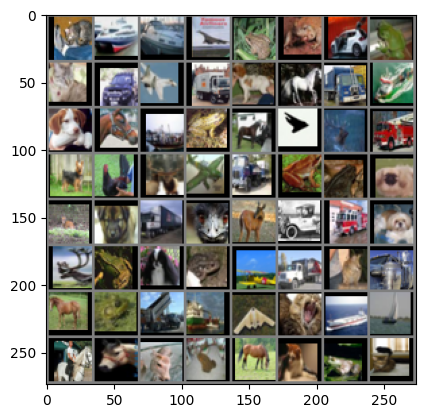

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog  truck ship  plane cat   ship  ship  horse horse deer  frog  horse cat   frog  cat  
Predicted:  cat   ship  ship  plane frog  cat   car   bird  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane plane truck deer  cat   deer  plane truck cat   frog  dog   deer  cat   truck cat   deer  truck truck dog   plane frog  dog   frog  plane truck cat   truck horse bird  truck ship  horse cat   ship  ship  horse cat   cat   dog   horse dog   ship  cat  


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Function to display an image
def image(img):
    img = img / 2 + 0.5  # unnormalize
    numpy_image = img.numpy()
    plt.imshow(np.transpose(numpy_image, (1, 2, 0)))
    plt.show()

dataiter = iter(validation_loader)
images, labels = next(dataiter)

# Move images and model to the same device
images = images.to(device)
model = model.to(device)

# Display the images
image(torchvision.utils.make_grid(images.cpu()))

# Print Ground Truth labels
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))

# Make predictions with the model
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(images) # Forward pass
    _, predicted = torch.max(outputs, 1) # Get the predicted class

# Print Predicted labels
print('Predicted: ', ' '.join(f'{classes[predicted[j].cpu()]:5s}' for j in range(len(predicted))))

In [28]:
# Define a dummy input for exporting
dummy_input = torch.randn(1, 3, 32, 32).to(device)

# Export the model to ONNX
onnx_file_path = "../api/model/vgg_cifar10_model.onnx"
torch.onnx.export(
    model.to(device),
    dummy_input,
    onnx_file_path,
    export_params=True,
    opset_version=11, # ONNX version
    do_constant_folding=True, # Optimize the model by folding constant ops
    input_names=["input"], # Name for the input layer
    output_names=["output"], # Name for the output layer
    dynamic_axes={
        "input": {0: "batch_size"}, # Allow variable batch size
        "output": {0: "batch_size"},
    },
)

print(f"Model exported to {onnx_file_path}")


Model exported to vgg_cifar10_model.onnx


In [29]:
# Test the ONNX file
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_session = ort.InferenceSession("../api/model/vgg_cifar10_model.onnx")

# Prepare input data (batch of 1, with 3x32x32 images)
input_data = np.random.randn(1, 3, 32, 32).astype(np.float32)

# Run inference
outputs = onnx_session.run(None, {"input": input_data})

print("ONNX model outputs:", outputs)

ONNX model outputs: [array([[-0.16510284, -1.0386162 ,  0.29108614,  0.1807763 , -0.53477144,
        -1.249768  , -0.30486843, -0.5664872 , -1.4755716 , -2.4626517 ]],
      dtype=float32)]
